In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [ ]:
IMG_SIZE = 48

from google.colab import drive

DATA_DIR = '/content/drive/MyDrive/images'
EMOTIONS = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Load the dataset (assuming emotions.csv is in the /content/ directory after unzipping)
csv_path = '/content/emotions.csv'
emotions_df = pd.read_csv(csv_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
emotions_df['set_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

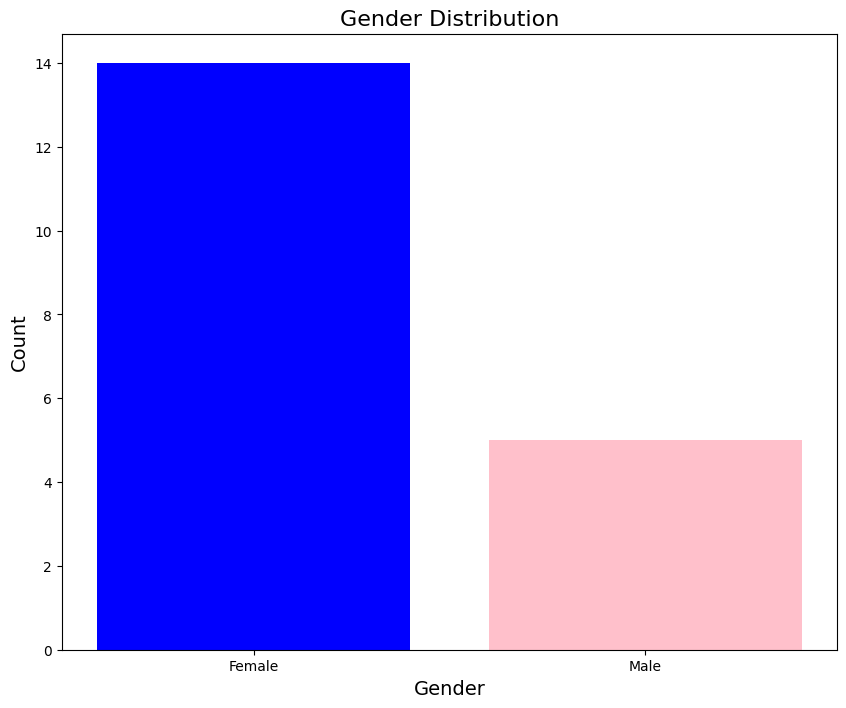

In [ ]:
# Gender distribution
plt.figure(figsize=(10, 8))
gender_counts = emotions_df['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'])
plt.title('Gender Distribution', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

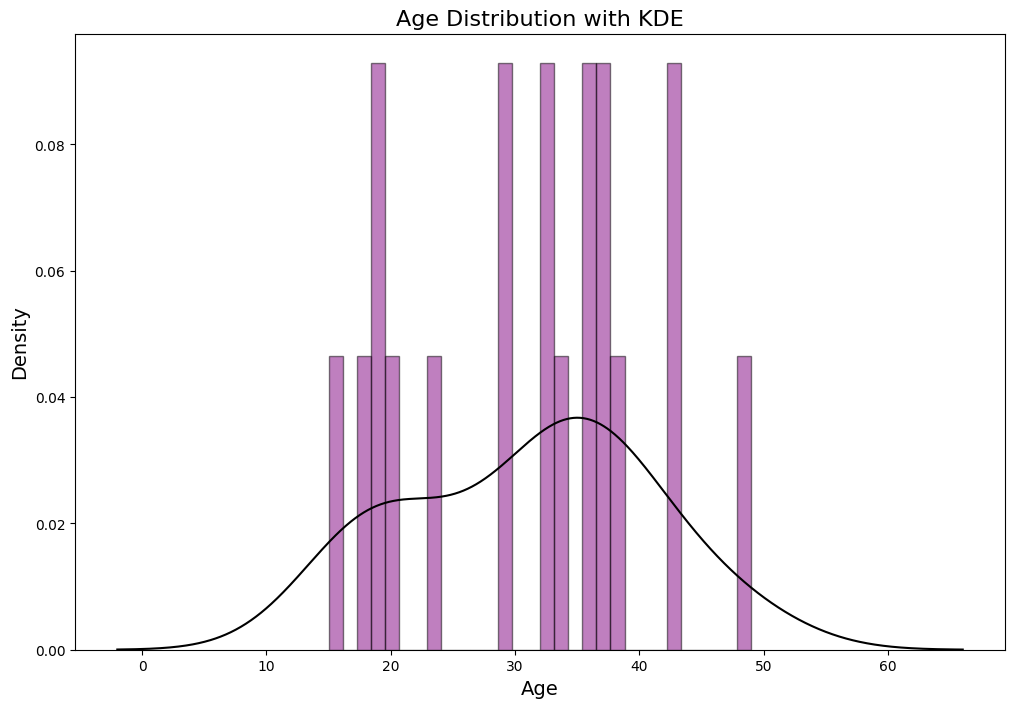

In [ ]:
# Age distribution with KDE
plt.figure(figsize=(12, 8))
emotions_df['age'].plot(kind='hist', bins=30, density=True, alpha=0.5, color='purple', edgecolor='black')
emotions_df['age'].plot(kind='kde', color='black')
plt.title('Age Distribution with KDE', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

<Figure size 1000x800 with 0 Axes>

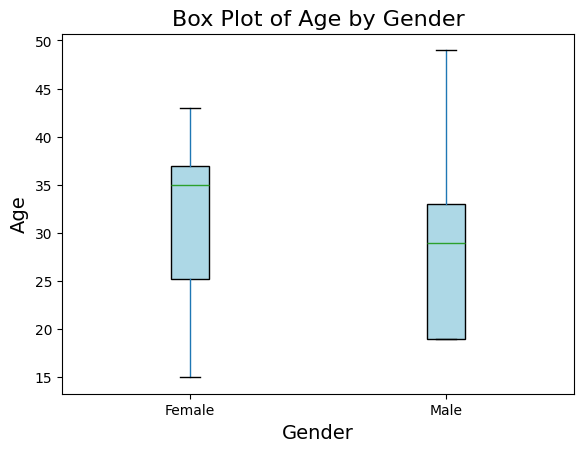

In [ ]:
# Box plot of age by gender
plt.figure(figsize=(10, 8))
emotions_df.boxplot(column='age', by='gender', grid=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box Plot of Age by Gender', fontsize=16)
plt.suptitle('')
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.xticks([1, 2], ['Female', 'Male'])
plt.show()

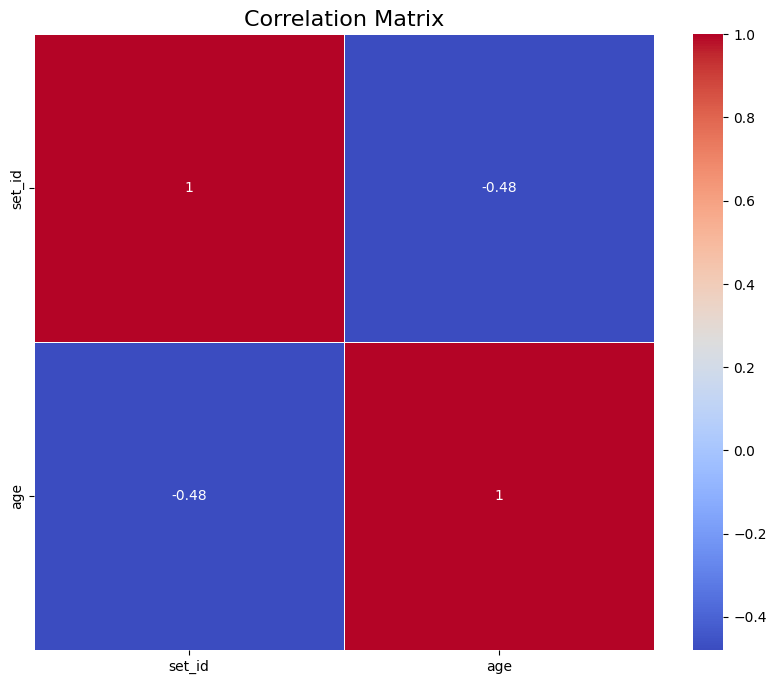

In [ ]:
plt.figure(figsize=(10, 8))
numeric_cols = emotions_df.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [ ]:
# Encode the gender column
label_encoder = LabelEncoder()
emotions_df['gender'] = label_encoder.fit_transform(emotions_df['gender'])

In [ ]:
# Function to load and preprocess images
def load_data():
    images = []
    labels = []

    for emotion_label, emotion in enumerate(EMOTIONS):
        # Get the directory for the current emotion
        emotion_dir = os.path.join(DATA_DIR, str(emotion_label))
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_file)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                images.append(img_resized)
                labels.append(emotion_label)  # Assigning label based on index
        else:
            print(f"Directory not found for emotion {emotion}: {emotion_dir}")

    return np.array(images), np.array(labels)

# Load the data
images, labels = load_data()

In [ ]:
# Normalize images
images = images / 255.0

# Encode labels to categorical
labels_categorical = to_categorical(labels, num_classes=len(EMOTIONS))

In [ ]:
# Check the distribution of the labels to ensure balance
print("Distribution of emotions:")
print(pd.Series(labels).value_counts())

Distribution of emotions:
0    8
1    8
2    8
3    8
4    8
5    8
6    8
7    8
Name: count, dtype: int64


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

In [ ]:
# Reshape for the model
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
# Model Training
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(EMOTIONS), activation='softmax')  # Ensure the correct number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.0966 - loss: 2.1009 - val_accuracy: 0.2308 - val_loss: 2.0662
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.1462 - loss: 2.0465 - val_accuracy: 0.0769 - val_loss: 2.0818
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step - accuracy: 0.1540 - loss: 2.0621 - val_accuracy: 0.0769 - val_loss: 2.0917
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.1697 - loss: 2.0522 - val_accuracy: 0.1538 - val_loss: 2.0849
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.2010 - loss: 1.9918 - val_accuracy: 0.0769 - val_loss: 2.0505
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step - accuracy: 0.2637 - loss: 1.9669 - val_accuracy: 0.5385 - val_loss: 1.9850
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3499 - loss: 1.8731 - val_accuracy: 0.5385 - val_loss: 1.9079
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2402 - loss: 1.8694 - val_accuracy: 0.5385 - val_loss: 1.

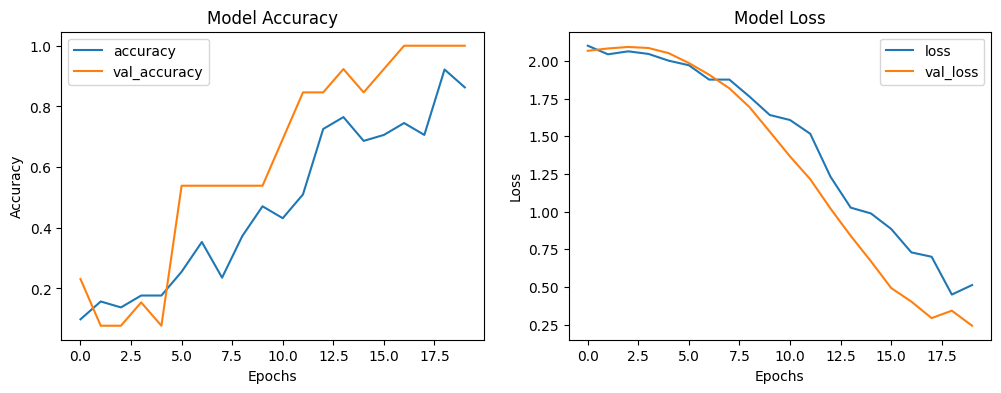

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


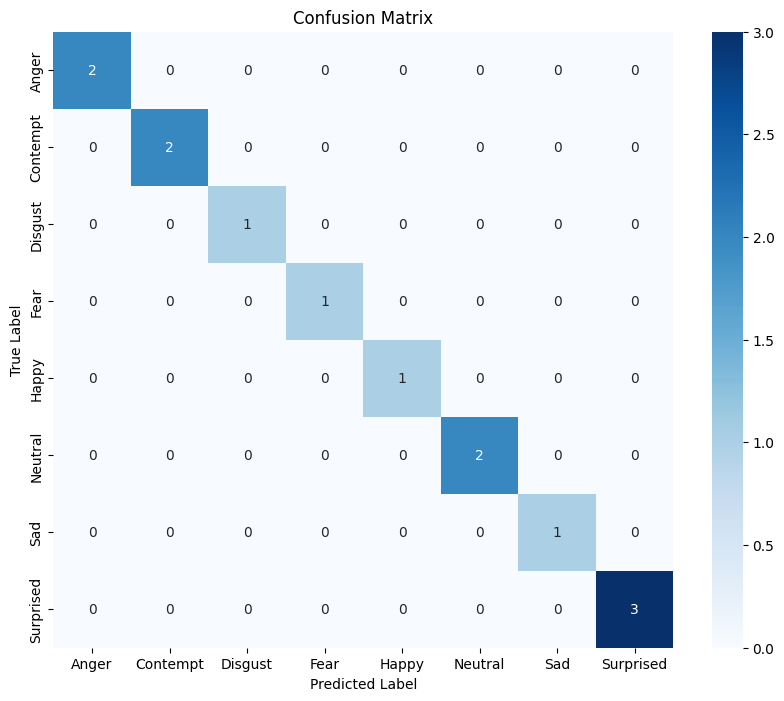

              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00         2
    Contempt       1.00      1.00      1.00         2
     Disgust       1.00      1.00      1.00         1
        Fear       1.00      1.00      1.00         1
       Happy       1.00      1.00      1.00         1
     Neutral       1.00      1.00      1.00         2
         Sad       1.00      1.00      1.00         1
   Surprised       1.00      1.00      1.00         3

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



In [ ]:
# Model Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_df = pd.DataFrame(cm, index=EMOTIONS, columns=EMOTIONS)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=EMOTIONS)
print(report)

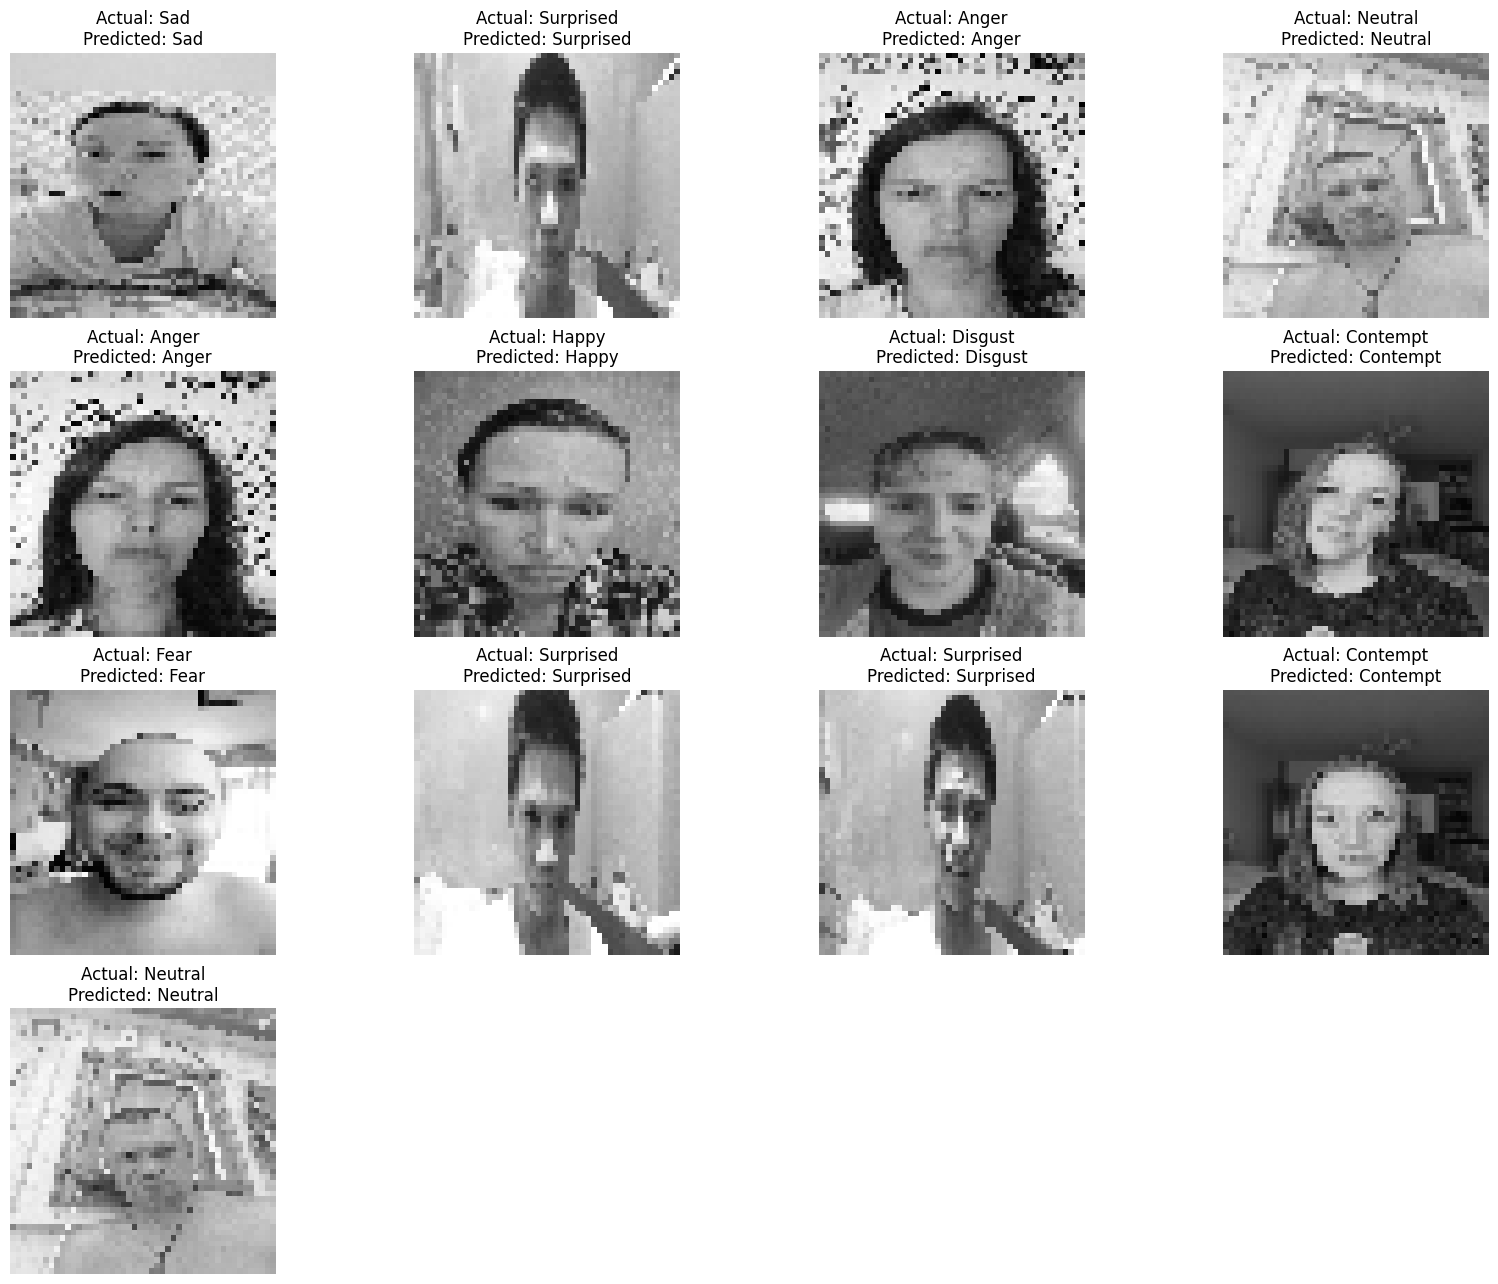

In [ ]:
# Display images with predicted and actual labels
num_images = min(20, len(X_test))
plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(5, 4, i + 1)
    img = (X_test[i] * 255).astype(np.uint8)  # Convert back to uint8
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"Actual: {EMOTIONS[y_true[i]]}\nPredicted: {EMOTIONS[y_pred_classes[i]]}")
    plt.axis('off')
plt.show()